In [1]:
import time
import dare
import copy
import math
import random
from enum import Enum
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.model_selection import train_test_split
import urllib.request as urllib
from DebugRF import Dataset, FairnessMetric

# Dataset class for preprocessing

In [2]:
'''Class for loading and preprocessing german credits dataset'''
class GermanCreditDataset(Dataset): 
    def __init__(self, rootTrain, rootTest):
        Dataset.__init__(self, rootTrain = rootTrain, rootTest = rootTest)
        self.train = self.trainDataset
        self.test = self.testDataset
        self.__renameColumnNames()
        self.trainProcessed, self.testProcessed = self.__preprocessDataset(self.train), self.__preprocessDataset(self.test)
        self.trainLattice, self.testLattice = self.__preprocessDatasetForCategorization(self.train), self.__preprocessDatasetForCategorization(self.test)
        
    def getDataset(self):
        return self.dataset, self.train, self.test

    def getDatasetWithNormalPreprocessing(self):
        return self.trainProcessed, self.testProcessed
    
    def getDatasetWithCategorizationPreprocessing(self, decodeAttributeValues = False):
        if decodeAttributeValues == True:
            return self.__decodeAttributeCodeToRealValues(self.trainLattice), self.__decodeAttributeCodeToRealValues(self.testLattice)
        return self.trainLattice, self.testLattice

    def __renameColumnNames(self):
        columns={'Column1': 'status_chec_acc', 
                'Column2': 'duration',
                'Column3': 'cred_hist',
                'Column4': 'purpose',
                'Column5': 'cred_amt',
                'Column6': 'savings',
                'Column7': 'employment',
                'Column8': 'intallment_rate',
                'Column9': 'status_and_sex',
                'Column10': 'debtors',
                'Column11': 'present_resi_since',
                'Column12': 'property',
                'Column13': 'age',
                'Column14': 'install_plans',
                'Column15': 'housing',
                'Column16': 'existing_creds',
                'Column17': 'job',
                'Column18': 'num_people_liable_to_maint',
                'Column19': 'telephone',
                'Column20': 'foreign_worker',
                'Column21': 'status'}
        self.train.rename(columns = columns, inplace = True)
        self.test.rename(columns = columns, inplace = True)

    def __preprocessDataset(self, dataset):
        df = copy.deepcopy(dataset)
        df['status_chec_acc'] = df['status_chec_acc'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int, errors='ignore')
        df['cred_hist'] = df['cred_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int, errors='ignore')
        df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
        df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)    
        df['sex'] = df['status_and_sex'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
        df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
        df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)        
        df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)    
        df = pd.concat([df, pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)
        df = pd.concat([df, pd.get_dummies(df['housing'], prefix='housing')],axis=1)
        df = pd.concat([df, pd.get_dummies(df['status_and_sex'], prefix='status_and_sex')],axis=1)
        df.loc[(df['cred_amt'] <= 2000), 'cred_amt'] = 0
        df.loc[(df['cred_amt'] > 2000) & (df['cred_amt'] <= 5000), 'cred_amt'] = 1
        df.loc[(df['cred_amt'] > 5000), 'cred_amt'] = 2    
        df.loc[(df['duration'] <= 12), 'duration'] = 0
        df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
        df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
        df.loc[(df['duration'] > 36), 'duration'] = 3
        df['age'] = df['age'].apply(lambda x : 1 if x > 30 else 0) # 1 if old, 0 if young
        df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)    
        df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
        df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
        df['status'] = df['status'].map({1: 1, 2: 0}).astype(int, errors='ignore')
        df.drop(columns=['purpose', 'status_and_sex','housing'], inplace = True)
        '''Moving status column at the end'''
        cols = list(df.columns.values) 
        cols.pop(cols.index('status')) 
        df = df[cols+['status']]
        return df
    
    def __preprocessDatasetForCategorization(self, dataset):
        df = copy.deepcopy(dataset)
        non_object_columns = [col for col in df.columns if df[col].dtypes != 'object']
        quantiles = self.train[non_object_columns].quantile([0, .25, .5, .75, 1.0], axis = 0)
        for col in non_object_columns:
            if col == 'age':
                df[col] = pd.cut(df[col], 
                               [quantiles[col][0.0] - 1, 30, quantiles[col][1.0] + 1], 
                               labels = ['age = young', 'age = old'], 
                               right = True, 
                               include_lowest = True)
            elif col == 'status':
                continue
            elif col == 'cred_amt':
                df[col] = pd.cut(df[col], 
                               [0, 1365.50001, 3972.25001, 18424.0001], 
                               labels = [str(col) + ' = low', str(col) + ' = medium', str(col) + ' = high'], 
                               right = True, 
                               include_lowest = True)
            else:
                df[col] = pd.cut(df[col], 
                               [quantiles[col][0.0] - 1, quantiles[col][0.50], math.inf], 
                               labels = [str(col) + ' = low', str(col) + ' = high'], 
                               right = True, 
                               include_lowest = True)
        df['status'] = df['status'].map({1: 1, 2: 0}).astype(int, errors='ignore')
        '''Moving status column at the end'''
        cols = list(df.columns.values) 
        cols.pop(cols.index('status')) 
        df = df[cols+['status']]
        return df
    
    def __decodeAttributeCodeToRealValues(self, dataset):
        df = copy.deepcopy(dataset)
        map_code_to_real = {
            "status_chec_acc": {
                "A11": "status_chec_acc = < 0 DM",
                "A12": "status_chec_acc = 0 <=..< 200DM",
                "A13": "status_chec_acc = > =200 DM",
                "A14": "status_chec_acc = no checking account"
            },
            "cred_hist": {
                "A30": "cred_hist = no credits taken / all credits paid back duly",
                "A31": "cred_hist = all credits at this bank paid back duly",
                "A32": "cred_hist = existing credits paid back duly till now",
                "A33": "cred_hist = delay in paying off in the past",
                "A34": "cred_hist = critical account / other credits existing (not at this bank)"
            },
            "purpose": {
                "A40": "purpose = car (new)",
                "A41": "purpose = car (used)",
                "A42": "purpose = furniture/equipment",
                "A43": "purpose = radio/television",
                "A44": "purpose = domestic appliances",
                "A45": "purpose = repairs",
                "A46": "purpose = education",
                "A47": "purpose = vacation - does not exist?",
                "A48": "purpose = retraining",
                "A49": "purpose = business",
                "A410": "purpose = others"
            },
            "savings": {
                "A61": "savings = ..<100 DM",
                "A62": "savings = 100 <= .. < 500 DM",
                "A63": "savings = 500 <= .. < 1000 DM",
                "A64" : "savings = ..>=1000 DM",
                "A65": "unknown/no savings account"
            },
            "employment": {
                "A71": "employment = unemployed",
                "A72": "employment = .. < 1 year",
                "A73": "employment = 1 <= .. < 4 years",
                "A74": "employment = 4 <= .. < 7 years",
                "A75": "employment = .. >= 7 years"
            },
            "status_and_sex": {
                "A91": "status_and_sex = male: divorced/separated",
                "A92": "status_and_sex = female: divorced/separated/married",
                "A93": "status_and_sex = male: single",
                "A94": "status_and_sex = male: married/widowed",
                "A95": "status_and_sex = femaled: single"
            },
            "debtors": {
                "A101": "debtors = none",
                "A102": "debtors = co-applicant",
                "A103": "debtors = guarantor"
            },
            "property": {
                "A121": "property = real estate",
                "A122": "property = building society savings agreement/life insurance",
                "A123": "property = car or other",
                "A124": "property = unknown / no property"
            },
            "install_plans": {
                "A141": "install_plans = bank",
                "A142": "install_plans = stores",
                "A143": "install_plans = none"
            },
            "housing": {
                "A151": "housing = rent",
                "A152": "housing = own",
                "A153": "housing = for free"
            },
            "job": {
                "A171": "job = unemployed / unskilled - non-resident",
                "A172": "job = unskilled - resident",
                "A173": "job = skilled employee / official",
                "A174": "job = management / self-employed / highly qualified employee / officer" 
            },
            "telephone": {
                "A191": "telephone = none",
                "A192": "telephone = yes, registered under customer's name"
            },
            "foreign_worker": {
                "A201": "foreign_worker = yes",
                "A202": "foreign_worker = no"
            }
        }
        object_columns = [col for col in df.columns if df[col].dtypes == 'object']
        for col in object_columns:
            df[col] = df[col].map(map_code_to_real[col]).fillna(df[col])
        return df

# DaRE-RF Accuracy Testing

In [3]:
def createSyntheticDataset(n_samples, n_features, n_classes, weights, test_size, random_state):
    X, Y = make_classification(n_samples = n_samples, 
                               n_features = n_features, 
                               n_informative = n_features - 2,
                               n_classes = n_classes,
                               weights = weights,
                               random_state = random_state)
    df = pd.DataFrame(X)
    columns = []
    for i in range(1, n_features + 1):
        columns.append('X' + str(i))
    df.columns = columns
    df['Y'] = Y
    trainX, testX, trainY, testY = train_test_split(df.drop('Y', axis = 1) , 
                                                    df['Y'], 
                                                    stratify = df['Y'], 
                                                    test_size = test_size,
                                                    random_state = random_state)
    trainX.reset_index(drop = True, inplace = True)
    testX.reset_index(drop = True, inplace = True)
    trainY.reset_index(drop = True, inplace = True)
    testY.reset_index(drop = True, inplace = True)
    return trainX, trainY, testX, testY

In [4]:
def generateRandomSubsetsOfDataset(df, num_subsets, supportRange):
    size = len(df)
    eps = 0.0000001
    subsetIndexLists = []
    for i in range(num_subsets):
        support = np.random.uniform(supportRange[0], supportRange[1] + eps)
        num_samples = (int)(support * size)
        #can create duplicate, so need to use set, but doesn't matter much for random subsets of small support
        indices = np.random.randint(1, size, num_samples)
        subsetIndexLists.append(indices)
    return subsetIndexLists

In [5]:
def getActualAccuracyForSubsets(subsets, trainX, trainY, testX, testY):
    actualAccuracy = []
    for subset in subsets:
        newTrainX = trainX.drop(trainX.index[subset]) 
        newTrainY = trainY.drop(trainY.index[subset])
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        rf.fit(newTrainX.to_numpy(), newTrainY.to_numpy())
        predictions = rf.predict(testX.to_numpy())
        accuracy = accuracy_score(testY.to_numpy(), predictions)
        actualAccuracy.append(accuracy)
    return actualAccuracy

In [6]:
def getSupportRangeText(supportRange):
    supp = ""
    if supportRange[1] <= 0.05:
        supp = "0% - 5%."
    elif supportRange[1] <= 0.15:
        supp = "5% - 15%."
    else:
        supp = "GTE 30%."
    return supp

def getTitleForAccuracyComparisonGraph(supportRange):
    supp = getSupportRangeText(supportRange)
    return "Effect on accuracy after DaRE-RF deletion operation on subsets of support " + supp 

def getDareRfAccuracyVsActualAccuracyGraph(dareRfAccuracy, actualAccuracy, supportRange):
        if len(actualAccuracy) == 0:
            return
        x = np.linspace(-10, 10, 1000)
        dareAcc = np.array(dareRfAccuracy).astype(float)
        actAcc = np.array(actualAccuracy).astype(float)
        minDare, maxDare = dareAcc.min(), dareAcc.max()
        minAct, maxAct = actAcc.min(), actAcc.max()
        minValue = minDare if minDare < minAct else minAct
        maxValue = maxDare if maxDare > maxAct else maxAct
        plt.figure(figsize = (10,10))
        plt.title(getTitleForAccuracyComparisonGraph(supportRange))
        plt.xlabel("DaRE-RF Subset Deletion Accuracy")
        plt.ylabel("Actual Accuracy via Retraining after Subset Deletion")
        plt.xlim(minValue - 0.025, maxValue + 0.025)
        plt.ylim(minValue - 0.025, maxValue + 0.025)
        plt.plot(dareAcc, actAcc, 'ro')
        plt.plot(x, x + 0, '-g')
        filename = "DaRE_RF_accuracy" + "_" + getSupportRangeText(supportRange) + ".png"
        plt.savefig(filename, bbox_inches='tight')
        plt.show()

In [7]:
def testDareRfRandomSubsetDeletionCapability(num_subsets, supportRange, trainX, trainY, testX, testY):
    subsets = generateRandomSubsetsOfDataset(trainX, num_subsets, supportRange)
    actualAccuracy = getActualAccuracyForSubsets(subsets, trainX, trainY, testX, testY)
    dareRfAccuracy = []
    for subset in subsets:
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        rf.fit(trainX.to_numpy(), trainY.to_numpy())
        rf.delete(subset)
        predictions = rf.predict(testX.to_numpy())
        accuracy = accuracy_score(testY.to_numpy(), predictions)
        dareRfAccuracy.append(accuracy)
    getDareRfAccuracyVsActualAccuracyGraph(dareRfAccuracy, actualAccuracy, supportRange)
    percent_change = [(dareRfAccuracy[i] - actualAccuracy[i]) for i in range(len(dareRfAccuracy))]
#     percent_change = [((dareRfAccuracy[i] - actualAccuracy[i]) * 100) / actualAccuracy[i]  for i in range(len(dareRfAccuracy))]
    abs_percent_change = [abs(x) for x in percent_change]
    mean = np.mean(abs_percent_change)
    var = np.var(abs_percent_change)
    max_change = np.max(percent_change)
    min_change = np.min(percent_change)
    print("Accuracy change percent mean, variance, min and max are: ", mean, var, min_change, max_change)
    return dareRfAccuracy, actualAccuracy, percent_change

In [8]:
def leaveOneOutDareDeletionCapability(trainX, trainY, testX, testY):
    size = len(trainX)
    actualAccuracy = []
    dareRfAccuracy = []
    for i in range(size):
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        newTrainX = trainX.drop(trainX.index[i]) 
        newTrainY = trainY.drop(trainY.index[i])
        rf.fit(newTrainX.to_numpy(), newTrainY.to_numpy())
        predictions = rf.predict(testX.to_numpy())
        accuracy = accuracy_score(testY.to_numpy(), predictions)
        actualAccuracy.append(accuracy)
        
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        rf.fit(trainX.to_numpy(), trainY.to_numpy())
        rf.delete(i)
        predictions = rf.predict(testX.to_numpy())
        accuracy = accuracy_score(testY.to_numpy(), predictions)
        dareRfAccuracy.append(accuracy)
    getDareRfAccuracyVsActualAccuracyGraph(dareRfAccuracy, actualAccuracy)
    percent_change = [((dareRfAccuracy[i] - actualAccuracy[i]) * 100) / actualAccuracy[i]  for i in range(len(dareRfAccuracy))]
    abs_percent_change = [abs(x) for x in percent_change]
    mean = np.mean(abs_percent_change)
    var = np.var(abs_percent_change)
    max_change = np.max(percent_change)
    min_change = np.min(percent_change)
    print("Accuracy change percent mean, variance, min and max are: ", mean, var, min_change, max_change)
    return dareRfAccuracy, actualAccuracy, percent_change

In [9]:
dataloader = GermanCreditDataset(rootTrain = "Dataset/german_train.csv",
                                 rootTest = "Dataset/german_test.csv")
train, test = dataloader.getDatasetWithNormalPreprocessing()
catTrain, catTest = dataloader.getDatasetWithCategorizationPreprocessing(decodeAttributeValues = True)

In [10]:
trainX = train.drop("status", axis = 1)
trainY = train["status"]
testX = test.drop("status", axis = 1)
testY = test["status"]

In [ ]:
dareRfAccuracy1, actualAccuracy1, percent_change1 = testDareRfRandomSubsetDeletionCapability(num_subsets = 1000, 
                                                                                             supportRange = [0.001, 0.05],
                                                                                             trainX = trainX,
                                                                                             trainY = trainY,
                                                                                             testX = testX,
                                                                                             testY = testY)

In [ ]:
dareRfAccuracy2, actualAccuracy2, percent_change2 = testDareRfRandomSubsetDeletionCapability(num_subsets = 1000, 
                                                                                             supportRange = [0.05, 0.15],
                                                                                             trainX = trainX,
                                                                                             trainY = trainY,
                                                                                             testX = testX,
                                                                                             testY = testY)

In [ ]:
dareRfAccuracy3, actualAccuracy3, percent_change3 = testDareRfRandomSubsetDeletionCapability(num_subsets = 1000, 
                                                                                             supportRange = [0.30, 0.99],
                                                                                             trainX = trainX,
                                                                                             trainY = trainY,
                                                                                             testX = testX,
                                                                                             testY = testY)

In [ ]:
dareRfAccuracy4, actualAccuracy4, percent_change4 = leaveOneOutDareDeletionCapability(trainX = trainX,
                                                                                      trainY = trainY,
                                                                                      testX = testX,
                                                                                      testY = testY)

# DaRE-RF Fairness Testing for Random Subsets

In [11]:
def getFairnessParityDifference(FM, priviledgedIndices, protectedIndices, predictions, groundTruth):
    if FM == FairnessMetric.SP:
        return getStatisticalParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth)
    elif FM == FairnessMetric.PP:
        return getPredictiveParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth)
    elif FM == FairnessMetric.EO:
        return getEqualizingOddsParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth) 

def getStatisticalParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth):
    y_pred_priviledged = predictions[priviledgedIndices]
    y_pred_protected = predictions[protectedIndices]
    spPri = len(np.where(y_pred_priviledged == 1)[0]) / (len(y_pred_priviledged) + 1)
    spPro = len(np.where(y_pred_protected == 1)[0]) / (len(y_pred_protected) + 1)
    return spPri - spPro

def getPredictiveParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth):
    y_pred_priviledged = predictions[priviledgedIndices]
    y_pred_protected = predictions[protectedIndices]
    ppPri = precision_score(groundTruth[priviledgedIndices].to_numpy(), y_pred_priviledged)
    ppPro = precision_score(groundTruth[protectedIndices].to_numpy(), y_pred_protected)
    return ppPri - ppPro

def getEqualizingOddsParityDifference(priviledgedIndices, protectedIndices, predictions, groundTruth):
    y_pred_priviledged = predictions[priviledgedIndices]
    y_pred_protected = predictions[protectedIndices]

    cnf_matrix_pri = confusion_matrix(groundTruth[priviledgedIndices].to_numpy(), y_pred_priviledged)
    FP_pri = (cnf_matrix_pri.sum(axis=0) - np.diag(cnf_matrix_pri)).astype(float)  
    FN_pri = (cnf_matrix_pri.sum(axis=1) - np.diag(cnf_matrix_pri)).astype(float)
    TP_pri = (np.diag(cnf_matrix_pri)).astype(float)
    TN_pri = (cnf_matrix_pri.sum() - (FP_pri + FN_pri + TP_pri)).astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_pri = TP_pri / (TP_pri + FN_pri)
    # Fall out or false positive rate
    FPR_pri = FP_pri/(FP_pri + TN_pri)

    cnf_matrix_pro = confusion_matrix(groundTruth[protectedIndices].to_numpy(), y_pred_protected)
    FP_pro = (cnf_matrix_pro.sum(axis=0) - np.diag(cnf_matrix_pro)).astype(float)  
    FN_pro = (cnf_matrix_pro.sum(axis=1) - np.diag(cnf_matrix_pro)).astype(float)
    TP_pro = (np.diag(cnf_matrix_pro)).astype(float)
    TN_pro = (cnf_matrix_pro.sum() - (FP_pro + FN_pro + TP_pro)).astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_pro = TP_pro / (TP_pro + FN_pro)
    # Fall out or false positive rate
    FPR_pro = FP_pro/(FP_pro + TN_pro)

    TPR_parity = TPR_pri[1] - TPR_pro[1]
    FPR_parity = FPR_pri[1] - FPR_pro[1]
    eo_parity = (TPR_parity + FPR_parity) / 2
    return eo_parity

def getFairnessMetricName(FM):
    metricName = ""
    if FM == FairnessMetric.SP:
        metricName = "SP"
    elif FM == FairnessMetric.PP:
        metricName = "PP"
    elif FM == FairnessMetric.EO:
        metricName = "EO"
    return metricName

def getTitleForFairnessComparisonGraph(FM, supportRange):
    supp = getSupportRangeText(supportRange)
    if FM == FairnessMetric.SP:
        return "Effect on statistical parity after DaRE-RF deletion operation on random subsets of support " + supp
    elif FM == FairnessMetric.PP:
        return "Effect on predictive parity after DaRE-RF deletion operation on random subsets of support " + supp 
    elif FM == FairnessMetric.EO:
        return "Effect on equalizing odds after DaRE-RF deletion operation on random subsets of support " + supp 
    
def getDareRfFairnessVsActualFairnessGraph(dareRfFairness, actualFairness, FM, supportRange):
        if len(actualFairness) == 0:
            return
        x = np.linspace(-10, 10, 1000)
        dareFM = np.array(dareRfFairness).astype(float)
        actFM = np.array(actualFairness).astype(float)
        minDare, maxDare = dareFM.min(), dareFM.max()
        minAct, maxAct = actFM.min(), actFM.max()
        minValue = minDare if minDare < minAct else minAct
        maxValue = maxDare if maxDare > maxAct else maxAct
        plt.figure(figsize = (10,10))
        plt.rcParams.update({'font.size': 22})
        plt.title(getTitleForFairnessComparisonGraph(FM, supportRange))
        plt.xlabel("DaRE-RF Subset Deletion Fairness")
        plt.ylabel("Actual Fairness via Retraining after Subset Deletion")
        plt.xlim(minValue - 0.025, maxValue + 0.025)
        plt.ylim(minValue - 0.025, maxValue + 0.025)
        plt.plot(dareFM, actFM, 'ro')
        plt.plot(x, x + 0, '-g')
        filename = getFairnessMetricName(FM) + "_" + getSupportRangeText(supportRange) + "_coherent.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.show()

def getActualFairnessForSubsets(subsets, FM, trainX, trainY, testX, testY):
    actualFairness = []
    privTestIndices = np.where(testX["age"] == 1)[0]
    protTestIndices = np.where(testX["age"] == 0)[0]
    for subset in subsets:
        newTrainX = trainX.drop(trainX.index[subset]) 
        newTrainY = trainY.drop(trainY.index[subset])
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        rf.fit(newTrainX.to_numpy(), newTrainY.to_numpy())
        predictions = rf.predict(testX.to_numpy())
        fairnessScore = getFairnessParityDifference(FM, privTestIndices, protTestIndices, predictions, testY)
        actualFairness.append(fairnessScore)
    return actualFairness

def testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets, supportRange, trainX, trainY, testX, testY, FM, generateSubsets = True, subsetsList = None):
    subsets = []
    if generateSubsets == True:
        print("Generating random subsets")
        subsets = generateRandomSubsetsOfDataset(trainX, num_subsets, supportRange)
    else:
        print("Using provided subsets")
        subsets = subsetsList
    actualFairness = getActualFairnessForSubsets(subsets, FM, trainX, trainY, testX, testY)
    privTestIndices = np.where(testX["age"] == 1)[0]
    protTestIndices = np.where(testX["age"] == 0)[0]
    dareRfFairness = []
    for subset in subsets:
        rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
        rf.fit(trainX.to_numpy(), trainY.to_numpy())
        rf.delete(subset)
        predictions = rf.predict(testX.to_numpy())
        fairnessScore = getFairnessParityDifference(FM, privTestIndices, protTestIndices, predictions, testY)
        dareRfFairness.append(fairnessScore)
    getDareRfFairnessVsActualFairnessGraph(dareRfFairness, actualFairness, FM, supportRange)
    percent_change = [(dareRfFairness[i] - actualFairness[i])  for i in range(len(dareRfFairness))]
#     percent_change = [(((dareRfFairness[i] - actualFairness[i]) * 100) / actualFairness[i])  for i in range(len(dareRfFairness))]
    abs_percent_change = [abs(x) for x in percent_change]
    mean = np.mean(abs_percent_change)
    var = np.var(abs_percent_change)
    max_change = np.max(percent_change)
    min_change = np.min(percent_change)
    print("Fairness change percent mean, variance, min and max are: ", mean, var, min_change, max_change)
    return dareRfFairness, actualFairness, percent_change

In [12]:
privTestIndices = np.where(testX["age"] == 1)[0]
protTestIndices = np.where(testX["age"] == 0)[0]
rf = dare.Forest(n_estimators = 100,
                         max_depth = 5, 
                         k = 8,  
                         topd = 1,
                         random_state = 1)
rf.fit(trainX.to_numpy(), trainY.to_numpy())
predictions = rf.predict(testX.to_numpy())
getFairnessParityDifference(FairnessMetric.PP, privTestIndices, protTestIndices, predictions, testY)

0.15108958837772402

In [13]:
supp5r = generateRandomSubsetsOfDataset(trainX, 1000, [0.001, 0.05])
supp15r = generateRandomSubsetsOfDataset(trainX, 1000, [0.05, 0.15])
supp30r = generateRandomSubsetsOfDataset(trainX, 1000, [0.30, 0.99])

Using provided subsets


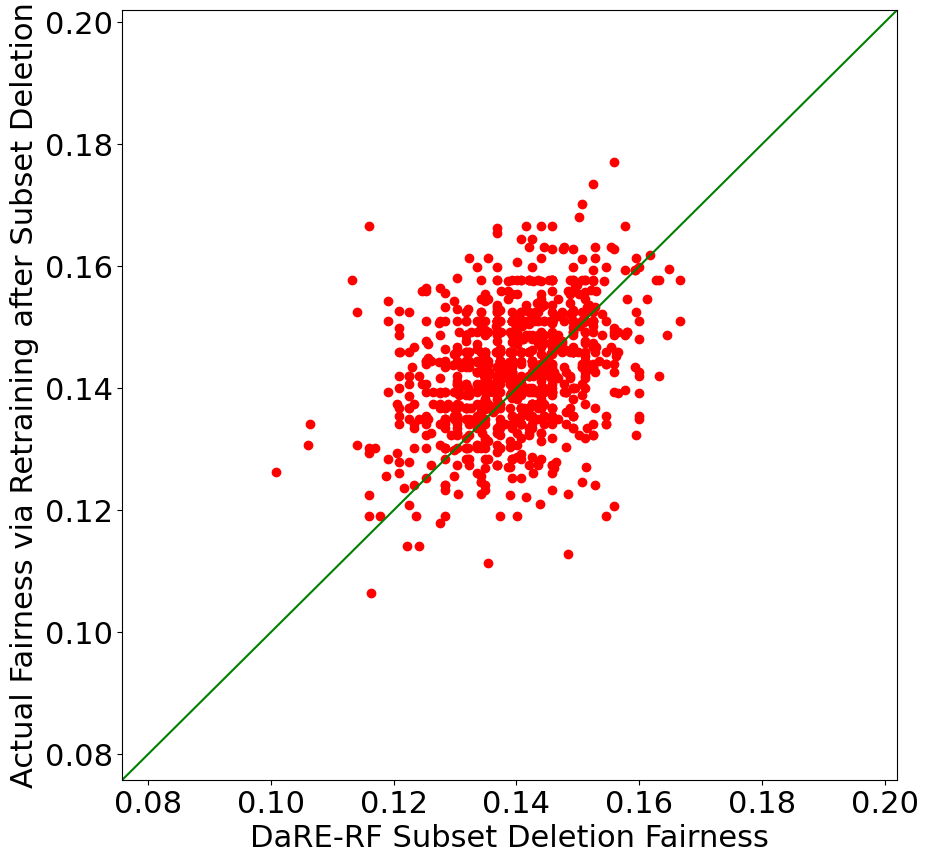

Fairness change percent mean, variance, min and max are:  0.008723580820287445 5.116003535667665e-05 -0.050640089911009545 0.03564848931466469


In [22]:
dareRfAccuracy5, actualAccuracy5, percent_change5 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                              supportRange = [0.001, 0.05],
                                                                                                              trainX = trainX,
                                                                                                              trainY = trainY,
                                                                                                              testX = testX,
                                                                                                              testY = testY,
                                                                                                              FM = FairnessMetric.PP,
                                                                                                              generateSubsets = False,
                                                                                                              subsetsList = supp5r)

Using provided subsets


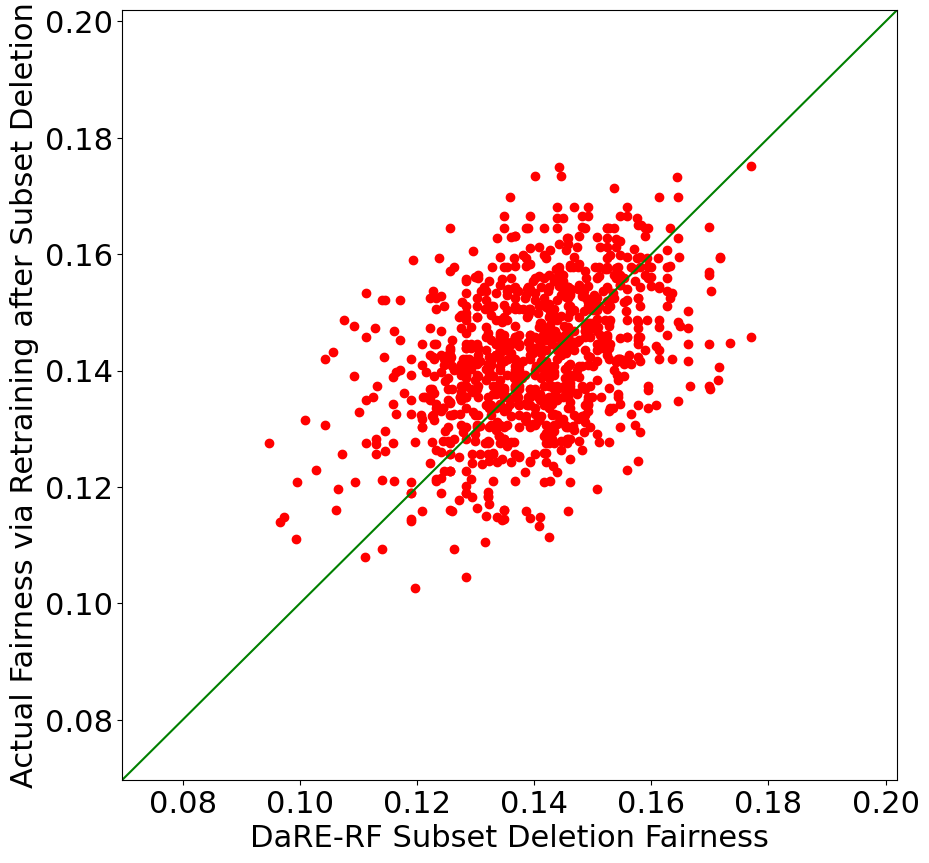

Fairness change percent mean, variance, min and max are:  0.010991626674162454 6.809035040904577e-05 -0.04204639602319804 0.033238778338103625


In [21]:
dareRfAccuracy6, actualAccuracy6, percent_change6 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                              supportRange = [0.05, 0.15],
                                                                                                              trainX = trainX,
                                                                                                              trainY = trainY,
                                                                                                              testX = testX,
                                                                                                              testY = testY,
                                                                                                              FM = FairnessMetric.PP,
                                                                                                              generateSubsets = False,
                                                                                                              subsetsList = supp15r)

Using provided subsets


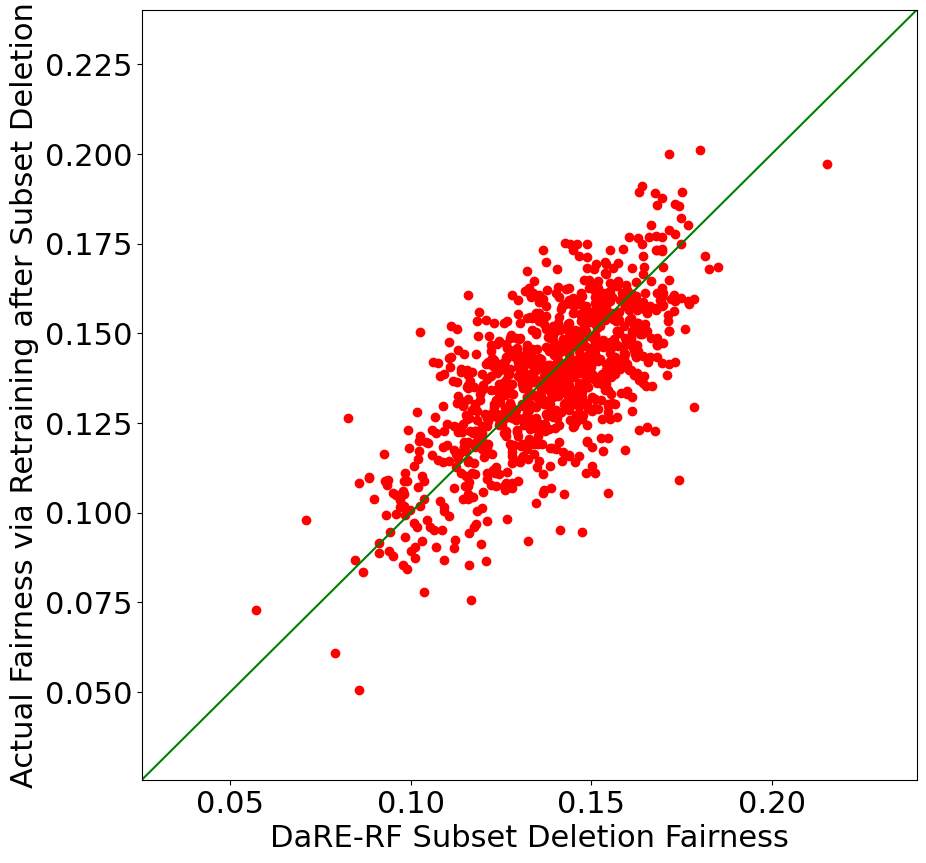

Fairness change percent mean, variance, min and max are:  0.012559598861526411 9.090338868147178e-05 -0.04778985699754135 0.06535626535626538


In [23]:
dareRfAccuracy7, actualAccuracy7, percent_change7 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                              supportRange = [0.30, 0.99],
                                                                                                              trainX = trainX,
                                                                                                              trainY = trainY,
                                                                                                              testX = testX,
                                                                                                              testY = testY,
                                                                                                              FM = FairnessMetric.PP,
                                                                                                              generateSubsets = False,
                                                                                                              subsetsList = supp30r)

# DaRE-RF Fairness Testing for Coherent Subsets

In [14]:
def getSubsetsOfVariousSupports(num_subsets, catTrain, catTest):
    supp5 = []
    supp15 = []
    supp30 = []
    attributeMap = {}
    categorizedDf = pd.concat([catTrain, catTest], ignore_index = True)
    for column in categorizedDf.columns:
        if column != "status":
            for value in categorizedDf[column].unique():
                attributeMap[value] = column
    literals = list(np.concatenate([categorizedDf[col].unique() for col in categorizedDf if col != "status"]))
    while len(supp5) != num_subsets or len(supp15) != num_subsets or len(supp30) != num_subsets:
        num_literals = np.random.randint(1, 5)
        subset = set(random.sample(literals, num_literals))
        requiredIndices = pd.Series(dtype = 'int') 
        firstItem = True
        for item in subset:
            if(firstItem == True):
                requiredIndices = (catTrain[attributeMap[item]] == item)
                firstItem = False
            requiredIndices = requiredIndices & (catTrain[attributeMap[item]] == item)
        subsetIndexList = (catTrain[requiredIndices].index.tolist())
        support =  len(subsetIndexList) / len(catTrain)
        if support > 0 and support < 0.05 and len(supp5) < num_subsets:
            supp5.append(subsetIndexList)
        elif support >= 0.05 and support <= 0.15 and len(supp15) < num_subsets:
            supp15.append(subsetIndexList)
        elif support >= 0.30 and len(supp30) < num_subsets:
            supp30.append(subsetIndexList)
    return supp5, supp15, supp30

In [15]:
supp5, supp15, supp30 = getSubsetsOfVariousSupports(1000, catTrain, catTest)

Using provided subsets


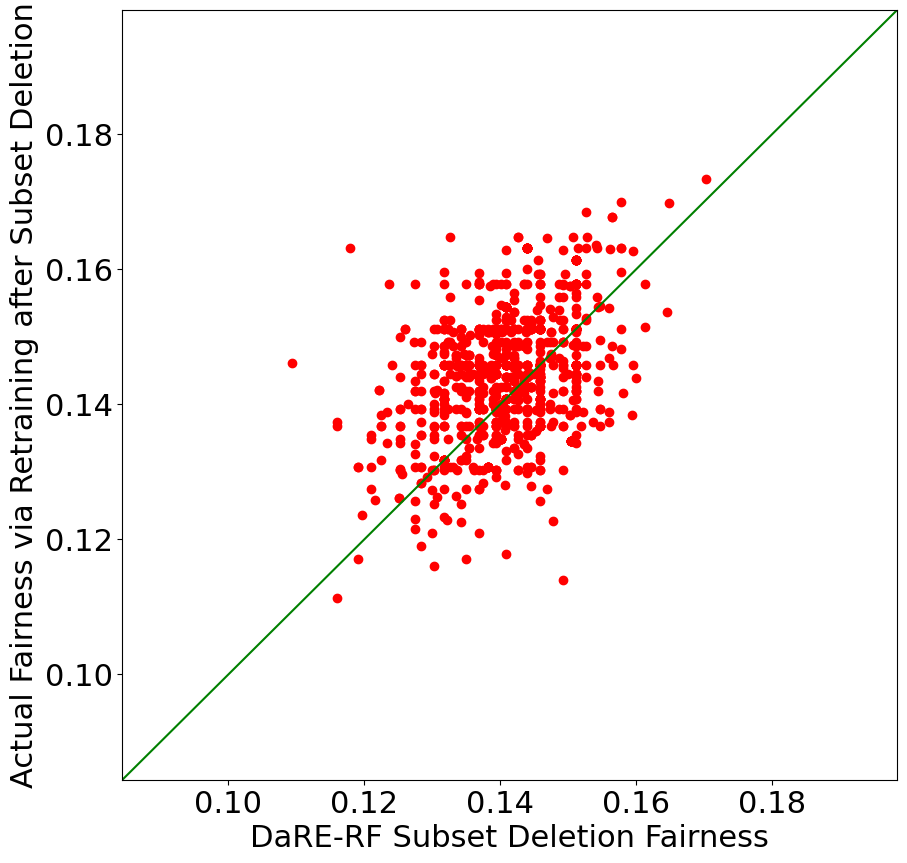

Fairness change percent mean, variance, min and max are:  0.007435199660221114 3.883812684918771e-05 -0.04524006946088521 0.035162765671240215


In [31]:
dareRfAccuracy8, actualAccuracy8, percent_change8 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                              supportRange = [0.001, 0.05],
                                                                                                              trainX = trainX,
                                                                                                              trainY = trainY,
                                                                                                              testX = testX,
                                                                                                              testY = testY,
                                                                                                              FM = FairnessMetric.PP,
                                                                                                              generateSubsets = False,
                                                                                                              subsetsList = supp5)

Using provided subsets


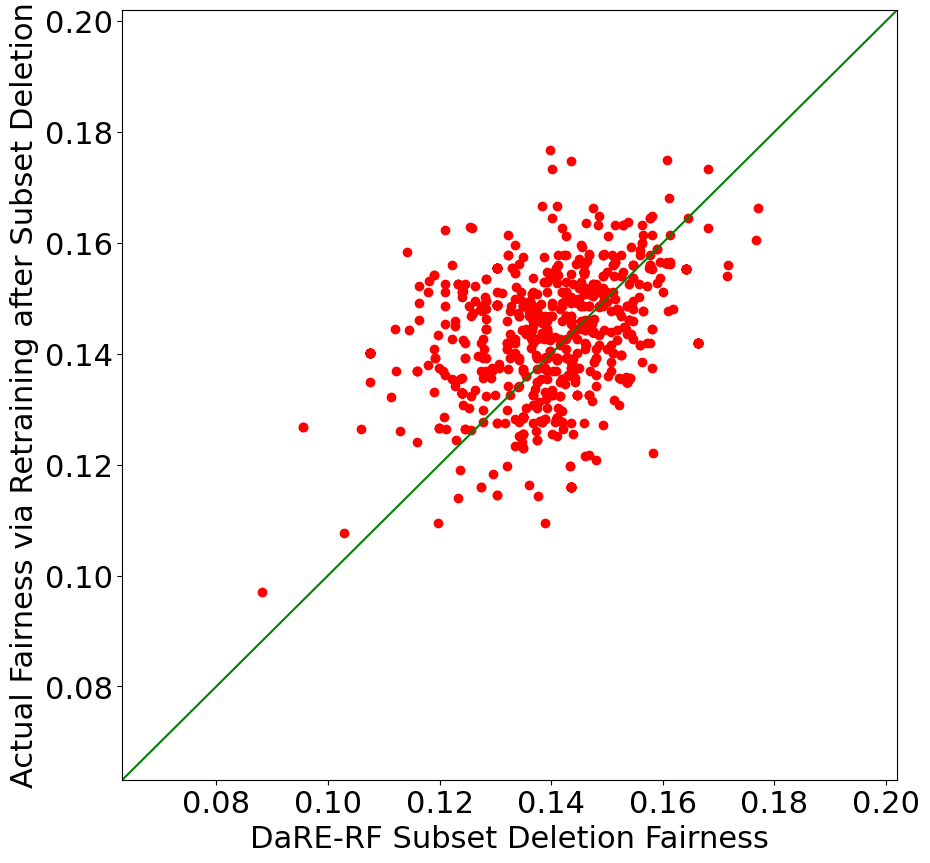

Fairness change percent mean, variance, min and max are:  0.011514850001118246 7.92967353540641e-05 -0.044181857696056426 0.036043064440630324


In [32]:
dareRfAccuracy9, actualAccuracy9, percent_change9 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                              supportRange = [0.05, 0.15],
                                                                                                              trainX = trainX,
                                                                                                              trainY = trainY,
                                                                                                              testX = testX,
                                                                                                              testY = testY,
                                                                                                              FM = FairnessMetric.PP,
                                                                                                              generateSubsets = False,
                                                                                                              subsetsList = supp15)

Using provided subsets


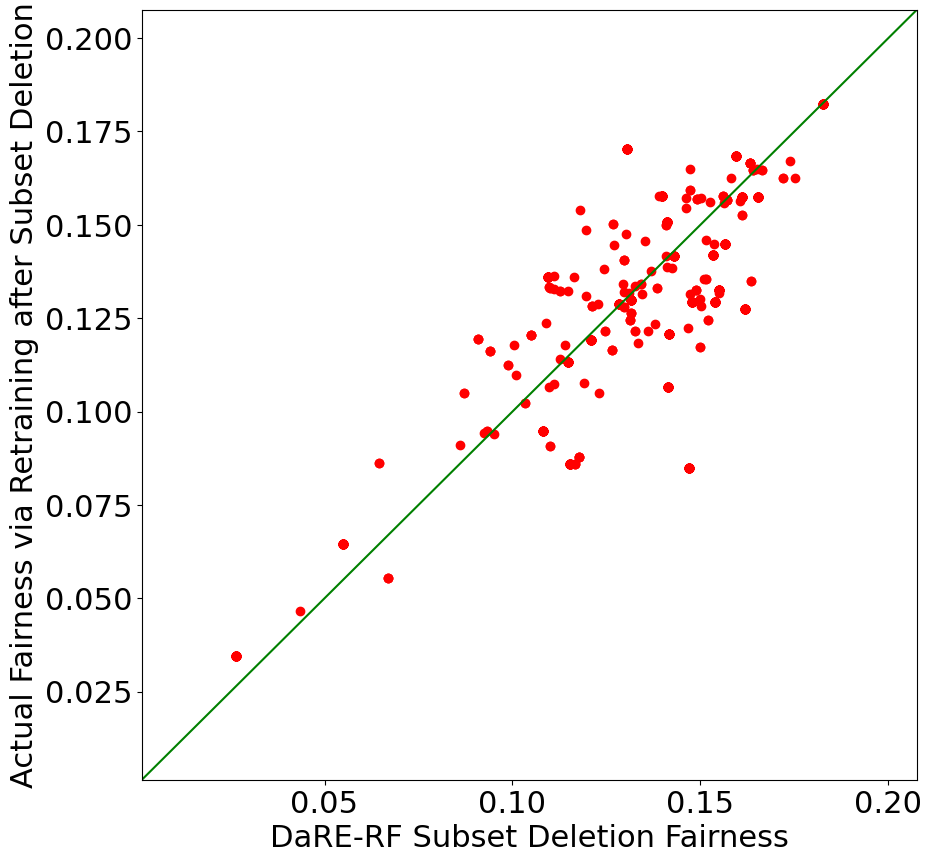

Fairness change percent mean, variance, min and max are:  0.015406145086987245 0.00018451660646475826 -0.03976226172627961 0.061965015195955875


In [33]:
dareRfAccuracy10, actualAccuracy10, percent_change10 = testDareRfRandomSubsetDeletionCapabilityForFairnessMetric(num_subsets = 1000, 
                                                                                                                 supportRange = [0.30, 0.99],
                                                                                                                 trainX = trainX,
                                                                                                                 trainY = trainY,
                                                                                                                 testX = testX,
                                                                                                                 testY = testY,
                                                                                                                 FM = FairnessMetric.PP,
                                                                                                                 generateSubsets = False,
                                                                                                                 subsetsList = supp30)